Converting PAH as Phenanthrene Equivalence (PAHphe in µg) from ship scrubber discharge data for the Salish Sea for 2019 into Salish Sea Atlantis contaminant forcing files of Phenanthrene (mg/m^3). Discharge data provided by Environment & Climate Change Canada (ECCC). 

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from netCDF4 import Dataset
from shapely.geometry import Point

In [2]:
ssam_shapefile = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
ssam = gpd.read_file(ssam_shapefile)
box_depth = ssam['BOTZ']
box_area = ssam['AREA']
box_volume = box_area * box_depth #m^3

numPolygons = 130
numLayers = 7

In [50]:
scrubber_data_path = '/ocean/rlovindeer/Atlantis/ShipScrubber/MEIT_2019_Data_SSAMDomain.csv'
scrubberdf = pd.read_csv(scrubber_data_path)
scrubberdf = scrubberdf.sort_values(by='date_time')

In [72]:
len(scrubberdf.lat)

398074

In [ ]:
for i in range(1, len(scrubberdf.lat)):

    if scrubberdf.BOX_ID([i]-1) == scrubberdf.BOX_ID([i]) and scrubberdf.date_time([i]-1) == scrubberdf.date_time([i]),
    scrubberdf.PAHphe([i]-1) + scrubberdf.PAHphe[(i)]

    

In [34]:
#scrubberdf.shape
#discharge = (scrubberdf.PAHphe * 0.001)/(scrubberdf.ww_tonnes * 1000) #mg # This yields a constant, 0.00264
PAHphe = scrubberdf.PAHphe * 0.001 #mg
lat = scrubberdf.lat
lon = scrubberdf.long
time = scrubberdf.date_time

In [57]:
minDate = time[0]
maxDate = time[(time.shape[0]-1)]

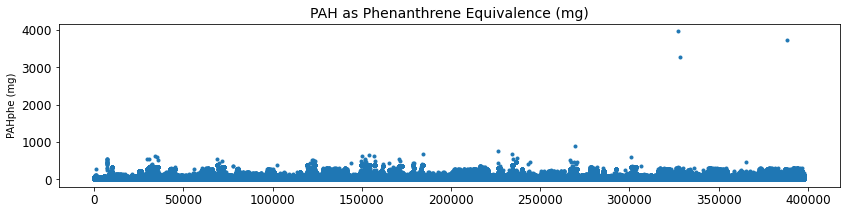

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(PAHphe, '.')
ax.set_title('PAH as Phenanthrene Equivalence (mg)', fontsize = 14)
ax.set_ylabel('PAHphe (mg)')
ax.tick_params(labelsize=12)

In [43]:
# Discharge release times
release_start = '2019-01-01'
release_end = '2091-12-31'
days_from_1950 = (2019-1950)*365

In [44]:
# Atlantis time steps
outputDT = 43100.00
stepsPerDay = int(86400.0/ outputDT)

In [ ]:
# Create netcdf forcing file

netcdfFileName = "Atlantis_Scrubber_PAH_2019.nc"
try:
    os.remove(netcdfFileName)
except:
    pass
ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)
Dataset.set_fill_on(ncfile)

# Dimensions
time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numPolygons)
z = ncfile.createDimension("z", numLayers)

# Variables
t = ncfile.createVariable("t",np.float64, ("t",))
Phenanthrene = ncfile.createVariable("Phenanthrene",np.float64,("t", "b", "z"))

# Attributes
Phenanthrene.units = "mgPAH/m^3"
Phenanthrene.long_name = "Phenanthrene"
Phenanthrene.missing_value = 0.0000
Phenanthrene.valid_min = 0.0000
Phenanthrene.valid_max = 100000000.0

#times.units = "seconds since " + d
t.units = "seconds since 1950-01-01 00:00:00 +10"
t.dt = outputDT
t.long_name = "time"

In [ ]:
# Populate Variables
seconds2019 = np.datetime64(maxDate) - np.datetime64(minDate)
numSteps = seconds2019/outputDT
numSteps = numSteps.astype(int)
timeData = np.arange(0,(numSteps)*outputDT,outputDT)
t[:] = timeData

DataFiller = np.zeros((numSteps, numPolygons, numLayers))

In [ ]:
Phenanthrene[:,:,:] = DataFiller

ncfile.close()